Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('dictionary: ', dictionary['ishiro'])  # 49884: 'ishiro'
print('reverse_dictionary: ', reverse_dictionary[1])
##del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5235, 3081, 12, 6, 195, 2, 3136, 46, 59, 156]
dictionary:  48569
reverse_dictionary:  the


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window  # can't have more skip-grams per word than available in window (2*skip_window)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
###    print('generate_batch: setup buffer: ', buffer)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
###    print('generate_batch: target: ', target)
###    print('generate_batch: targets_to_avoid: ', targets_to_avoid)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]  ### fill sequence: batch[-0,1- -2,3- -4,5- -6,7-]
      labels[i * num_skips + j, 0] = buffer[target]   # Random target in neighborhood of skip window center.
###      print('generate_batch: j, buffer: ', j, buffer)
###      print('generate_batch: j, skip_window: ', j, skip_window)
###      print('generate_batch: j, target: ', j, target)
###      print('generate_batch: j, targets_to_avoid: ', j, targets_to_avoid)
###      print('generate_batch: j, batch: ', j, batch)
###      print('generate_batch: j, labels: ', j, labels)
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2), (2,2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips_per_word = %d and skip_window = %d:' % (num_skips, skip_window)) # num_skips is num_skipgrams/word
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips_per_word = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips_per_word = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'a', 'term', 'originated', 'originated', 'as', 'of', 'term']

with num_skips_per_word = 2 and skip_window = 2:
    batch: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
    labels: ['term', 'a', 'of', 'as', 'as', 'abuse', 'first', 'abuse']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
###num_steps = 100001
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
  print('reverse_dictionary[10] = ', reverse_dictionary[10])
  print('final_embeddings[10,:] = ', final_embeddings[10,:])


Initialized
Average loss at step 0: 7.783315
Nearest to war: hauk, berzelius, guarantee, fixture, physiology, survives, apo, pontiac,
Nearest to nine: lichtenberg, trainee, dominance, progression, attractive, earl, aconcagua, gan,
Nearest to between: exploitation, rodriguez, carte, icrm, australis, boiler, abigail, wellcome,
Nearest to their: testimony, inverness, safest, teenage, conic, bitchx, wes, cannae,
Nearest to was: teenager, legislate, schl, precocious, montego, nests, include, model,
Nearest to five: nationals, donny, messengers, activate, kid, hutcheson, ct, exclave,
Nearest to while: escorting, yog, undesirable, estimator, encryption, thickness, sgml, lenz,
Nearest to zero: rosebud, stallions, equ, placement, pacifica, belarusian, habitus, hamish,
Nearest to can: disabilities, kannada, carbonic, joanne, flavour, oxus, manna, myrna,
Nearest to such: applies, grapevine, kitty, mahavira, kuiper, gl, postman, h,
Nearest to seven: momentous, rinnan, naphtali, render, brussel, in

In [8]:
###num_points = 400
num_points = 11

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
###two_d_embeddings = tsne.fit_transform(final_embeddings[10:15, :])

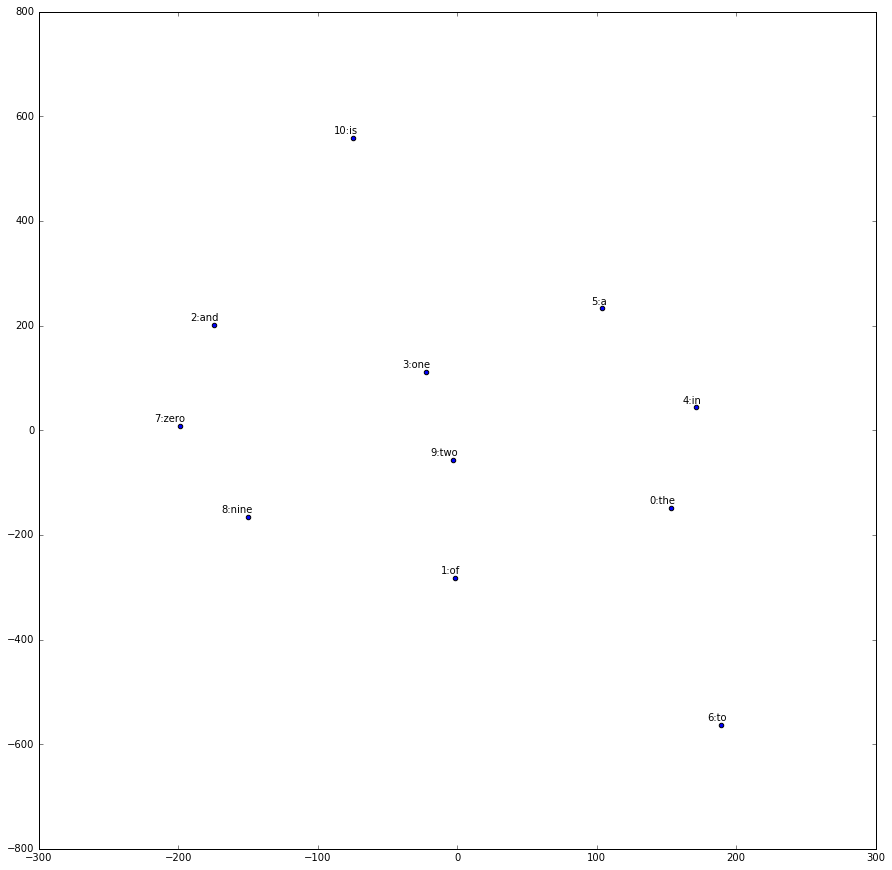

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
###    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
###                   ha='right', va='bottom')
    pylab.annotate(str(i)+':'+label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [32]:
#
# Generate mapping for CBOW model.
# Example, for window of size 2.
# data[i-2], data[i-1], data[i+1], data[i+2] 
# should all map to data[i]
#
#
###vocabulary_size = 6000
data_index = 0
random.seed(12343)  # for testing
import sklearn.metrics.pairwise as smp

def generate_batch_cbow(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window  # can't have more skip-grams per word than available in window (2*skip_window)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
###    print('generate_batch: setup buffer: ', buffer)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
###    print('generate_batch: target: ', target)
###    print('generate_batch: targets_to_avoid: ', targets_to_avoid)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
###        print('target = ', target)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[target]  ### fill sequence: batch[-0,1- -2,3- -4,5- -6,7-]
      labels[i * num_skips + j, 0] = buffer[skip_window]   # Random target in neighborhood of skip window center.
###      print('generate_batch: j, buffer: ', j, buffer)
###      print('generate_batch: j, skip_window: ', j, skip_window)
###      print('generate_batch: j, target: ', j, target)
###      print('generate_batch: j, targets_to_avoid: ', j, targets_to_avoid)
###      print('generate_batch: j, batch: ', j, batch)
###      print('generate_batch: j, labels: ', j, labels)
###    for iSkip in range(2*skip_window+1):  # skip to non-overlapping words
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)  # original calculation
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2), (2,2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    # num_skips is num_skipgrams/word
    print('\nwith num_skips_per_word = %d and skip_window = %d:' % (num_skips, skip_window)) 
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
#
# Create the computation graph for CBOW
#
###batch_size = 128  #original
batch_size = 8
embedding_size = 5 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
num_skips = 4 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
print('random.sample(range(valid_window) = ', random.sample(range(valid_window), 2))
###cbow_array = ['anarchism', 'originated', 'a', 'term']  # should predict 'as'
###against early working class radicals
###cbow_array = ['against', 'early', 'class', 'radicals']  # should predict 'working'
cbow_array = ['originated']  # should predict 'as'
cbow_array_idx = []
for iWord in cbow_array:   
  cbow_array_idx.append(dictionary[iWord])
num_sampled = 64 # Number of negative examples to sample.
print('cbow_array_idx: ', cbow_array_idx)

tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
  tf.set_random_seed(1234)

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  valid_dataset_cbow = tf.constant(cbow_array_idx, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0, seed=12345))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size), seed=12347))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print('embed = ', embed)
  # Compute the softmax loss, using a sample of the negative labels each time.
  #
  # For CBOW, we should be training on the sum of the embedding vectors.
  # Create a reduced size set of inputs (reduced by the embedding sums)
  # embed_segment_final = [ 0 0 0 0 1 1 1 1 2 2 2 2 .... 127 127 127 127] for skip_window=2
  # Used to create segment sums (summing up elements at the respective indices)
  #
  embed_segment = tf.range(0, batch_size, 1)
###  divisor_tensor = tf.constant(2*skip_window, dtype=tf.int32, shape=[batch_size])
  divisor_tensor = tf.constant(1, dtype=tf.int32, shape=[batch_size])
  embed_segment_final = tf.floordiv(embed_segment,divisor_tensor)
  embed_segment_sum = tf.segment_sum(embed, embed_segment_final)
  print('embed_segment:' , embed_segment)
  print('divisor_tensor:', divisor_tensor)
  print('embed_segment_final:', embed_segment_final)
  print('embed_segment_sum: ', embed_segment_sum)

###  temp0 = tf.constant([3])
###  print('temp0 = ', temp0)
###  print('temp0.shape = ', temp0.shape)
###  temp1 = tf.constant([ [4,5,6,7] ] )
###  print('temp1 = ', temp1)
###  print('temp1.shape = ', temp1.shape)
###  temp2 = tf.constant([ [4,5,6,7], [10,15,16,-21] ])
###  print('temp2 = ', temp2)
###  print('temp2.shape = ', temp2.shape)
###  temp3 = tf.constant([ [ [4,5,6,7], [10,15,16,-21] ], 
###                       [ [14,15,16,17], [110,115,116,-121] ], 
###                       [ [24,25,26,27], [210,215,216,-221] ] ])
###  print('temp3 = ', temp3)
###  print('temp3.shape = ', temp3.shape)
### labels_cbow = tf.placeholder(tf.int32, shape=[batch_size//(2*skip_window), 1])
###  labels_cbow = tf.strided_slice(train_labels, [0,0], [batch_size,1], [2*skip_window,1])
  labels_cbow = tf.strided_slice(train_labels, [0,0], [batch_size,1], [1,1])

  #
  # Compute the loss
  #
###  loss = tf.reduce_mean(
###    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
###                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  logits = tf.matmul(embed, tf.transpose(softmax_weights))
  print('logits = ', logits)
  logits = tf.nn.bias_add(logits, softmax_biases)
  labels_one_hot = tf.one_hot(tf.squeeze(train_labels), vocabulary_size)
  print('labels_one_hot = ', labels_one_hot)
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
      labels=labels_one_hot,
      logits=logits) )
    
###  loss = tf.reduce_mean(
###    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_segment_sum,
###                               labels=labels_cbow, num_sampled=num_sampled, num_classes=vocabulary_size))

###  loss = tf.reduce_mean(
###     tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_segment_sum,
###                                labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))    
    
  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
###  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm

  valid_embeddings = tf.nn.embedding_lookup( normalized_embeddings, valid_dataset )

  valid_embeddings_non_norm_cbow = tf.nn.embedding_lookup(embeddings, valid_dataset_cbow)

  myResSum = np.sum(valid_embeddings_non_norm_cbow,axis=0, keepdims=True) # Look up sum of words around 'as'
 
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  similarity_cbow = tf.matmul(myResSum, tf.transpose(normalized_embeddings))

#
# Execute the graph.
#
###num_steps = 100001
###num_steps = 30001
num_steps = 2001
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()  
  print('Initialized')
  data_index = 0 #start the data at the beginning.
  average_loss = 0
  for step in range(num_steps):
    if step <1: #overfit for testing.
      batch_data, batch_labels = generate_batch_cbow(
        batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l, myRes, my_embeddings, my_labels_cbow = \
        session.run([optimizer, loss, embed_segment_sum, embed, labels_cbow], feed_dict=feed_dict)
    average_loss += l
    if step % 100 == 0:
      if step > 0:
        average_loss = average_loss / 100
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 100 == 0:
      continue
###      sim = similarity.eval()
###      for i in range(valid_size):
###        valid_word = reverse_dictionary[valid_examples[i]]
###        top_k = 8 # number of nearest neighbors
###        nearest = (-sim[i, :]).argsort()[1:top_k+1]
###        log = 'Nearest to %s:' % valid_word
###        for k in range(top_k):
###          close_word = reverse_dictionary[nearest[k]]
###          log = '%s %s,' % (log, close_word)
###        print(log)
# do a vector sum of several words in bag to see what the predicted word is        
###        sim = similarity.eval()
      
###      print('myRes shape = ', myRes.shape)
###      print('myRes[0,0] = ', myRes[0,0],)
###      print('myRes[0,1] = ', myRes[0,1])
###      print('myRes[1,0] = ', myRes[1,0])
###      print('myRes[1,127] = ', myRes[1,127])
###      print('batch_data = ', batch_data)
      for iWord in batch_data:
        print('iWord = ', iWord)
        print('batch word = ', reverse_dictionary[iWord])
    
      for iWord in batch_labels:
        print('iWord = ', iWord[0])
        print('batch label = ', reverse_dictionary[iWord[0]])
###      print('my_labels_cbow.shape = ', my_labels_cbow.shape)
###        print('my_labels_cbow = ', my_labels_cbow)
###      sim_cbow = similarity_cbow.eval()
#Look up closest embedding in angle space
###      top_k = 8 # number of nearest neighbors
###      print('sim_cbow = ', sim_cbow, sim_cbow.shape)
###      nearest = (-sim_cbow[0,:]).argsort()[1:top_k+1]
###      for k in range(top_k):
###        close_word = reverse_dictionary[nearest[k]]
###        print(close_word)
        
###  final_embeddings = normalized_embeddings.eval()
  
###  print('reverse_dictionary[10] = ', reverse_dictionary[10])
###  print('final_embeddings[0:4,:] = ', final_embeddings[0:4,:])

###  print('myRes[0:2,:] = ', myRes[0:2,:])
      print('my_embeddings-term[0]= ', my_embeddings[0,:])
      print('my_embeddings-a[1] = ', my_embeddings[1,:])
      print('my_embeddings-anarchism[2] = ', my_embeddings[2,:])
      print('my_embeddings-originated[3] = ', my_embeddings[3,:])
      print('my_embeddings-term[4]= ', my_embeddings[4,:])
      print('my_embeddings-a[5] = ', my_embeddings[5,:])
      print('my_embeddings-anarchism[6] = ', my_embeddings[6,:])
      print('my_embeddings-originated[7] = ', my_embeddings[7,:])
      print('similarity 0-1 = ', smp.cosine_similarity( my_embeddings[0,:].reshape(1,-1), my_embeddings[1,:].reshape(1,-1) ))
      print('similarity 0-2 = ', smp.cosine_similarity( my_embeddings[0,:].reshape(1,-1), my_embeddings[2,:].reshape(1,-1) ))
      print('similarity 0-3 = ', smp.cosine_similarity( my_embeddings[0,:].reshape(1,-1), my_embeddings[3,:].reshape(1,-1) ))
      print('similarity 0-4 = ', smp.cosine_similarity( my_embeddings[0,:].reshape(1,-1), my_embeddings[4,:].reshape(1,-1) ))
      print('similarity 0-5 = ', smp.cosine_similarity( my_embeddings[0,:].reshape(1,-1), my_embeddings[5,:].reshape(1,-1) ))
      print('similarity 0-6 = ', smp.cosine_similarity( my_embeddings[0,:].reshape(1,-1), my_embeddings[6,:].reshape(1,-1) ))
      print('similarity 0-7 = ', smp.cosine_similarity( my_embeddings[0,:].reshape(1,-1), my_embeddings[7,:].reshape(1,-1) ))
      print()
###  print('my_embeddings-as[12,:] = ', my_embeddings[12,:])
###  print('final_embedding[195,:] = ', final_embeddings[195,:])
###  print('final_embedding[6,:] = ', final_embeddings[6,:])
###  print('final_embedding[5235,:] = ', final_embeddings[5235,:])
###  print('final_embedding[3083,:] = ', final_embeddings[3083,:])
###  print('final_embedding[12,:] = ', final_embeddings[12,:])
###  print('reverse_dictionary[195] = ', reverse_dictionary[195])
###  print('reverse_dictionary[6] = ', reverse_dictionary[6])
###  print('reverse_dictionary[5235] = ', reverse_dictionary[5235])
###  print('reverse_dictionary[3083] = ', reverse_dictionary[3083])
###  print('reverse_dictionary[12] = ', reverse_dictionary[12])
  final_embeddings = embeddings.eval()
  for iWord in batch_data:
    for jWord in batch_data:
      print('iWord_idx, jWord_idx = ', iWord, jWord)
      print('word(i), word(j) = ', reverse_dictionary[iWord], reverse_dictionary[jWord] )
      print('similarity (i,j) = ', smp.cosine_similarity( final_embeddings[iWord,:].reshape(1,-1), final_embeddings[jWord,:].reshape(1,-1) ))
      print()

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips_per_word = 2 and skip_window = 1:
    batch: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a']
    labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

with num_skips_per_word = 4 and skip_window = 2:
    batch: ['a', 'originated', 'anarchism', 'term', 'of', 'as', 'originated', 'term']
    labels: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']

with num_skips_per_word = 2 and skip_window = 2:
    batch: ['term', 'a', 'as', 'term', 'of', 'abuse', 'first', 'abuse']
    labels: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
random.sample(range(valid_window) =  [11, 29]
cbow_array_idx:  [3081]
embed =  Tensor("embedding_lookup:0", shape=(8, 5), dtype=float32, device=/device:CPU:0)
embed_segment: Tensor("range:0", shape=(8,), dtype=int32, device=/device:CPU:0)
divisor_tensor: Tensor("Const_2:0", shape=(8,), dtype=int32, device=/device:CPU:0)
embed_segment_final

final_embedding[195,:] =  [-1.67185223 -1.32088435  1.05217397  1.92196405  1.20249104]
final_embedding[6,:] =    [-1.67171669 -1.32100761  1.04765058  1.93373191  1.19013822]
final_embedding[5235,:] = [-1.67555869 -1.32475734  1.05065691  1.92173862  1.19525731]
final_embedding[3083,:] = [-1.66747761 -1.32519245  1.04749775  1.93262446  1.19291449]

-----  
random.sample(range(valid_window) =  [11, 29]  
cbow_array_idx:  [5235, 3081, 6, 195]  
embed_segment: Tensor("range:0", shape=(128,), dtype=int32, device=/device:CPU:0)  
divisor_tensor: Tensor("Const_2:0", shape=(128,), dtype=int32, device=/device:CPU:0)  
embed_segment_final: Tensor("floordiv:0", shape=(128,), dtype=int32, device=/device:CPU:0)  
embed_segment_sum:  Tensor("SegmentSum:0", shape=(?, 128), dtype=float32, device=/device:CPU:0)  
Initialized  
Average loss at step 0: 8.190059  
myRes shape =  (32, 128)  
myRes[0,0] =  1.05843  
desertification  
unaffected  
agglomeration  
judicious  
outkast  
yunnan  
caulfield  
banned  
Average loss at step 2000: 4.508498  
Average loss at step 4000: 4.113087  
Average loss at step 6000: 3.928141  
Average loss at step 8000: 3.923872  
Average loss at step 10000: 3.884587  
myRes shape =  (32, 128)  
myRes[0,0] =  -0.35054  
desertification  
alchemy  
armenia  
outkast  
papua  
myanmar  
banned  
tuva  

TestData:
anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the

anarchism originated as a term  
of abuse first used against  
early working class radicals including  